In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data as dataloader
import torch.nn as nn


In [2]:
#transformation of PIL data into tensor format  
transformation_operations = transforms.Compose([transforms.ToTensor()])

In [3]:
#getting PIL data
train_dataset = torchvision.datasets.MNIST(root='./data',train= True,download=True, transform = transformation_operations )
val_dataset = torchvision.datasets.MNIST(root='./data',train= False,download=True, transform = transformation_operations )


In [4]:
#define variables
batch_size = 64
num_classes = 10
num_channels = 1
img_size = 28
patch_size = 7
patch_num = (img_size//patch_size)**2
learning_rate =0.001
attention_heads = 4
embed_dim = 16
transformer_blocks = 6
mlp_nodes = 16
epochs = 5


In [5]:
train_data = dataloader.DataLoader(train_dataset, batch_size = batch_size, shuffle= True)
val_data = dataloader.DataLoader(val_dataset, batch_size= batch_size, shuffle = True)

In [6]:
#class for patchembeeding - part1 of the vit architecture
class PatchEmbedding(nn.Module):

        def __init__(self):
                super().__init__()
                self.patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size= patch_size, stride= patch_size)

        def forward(self, x):
                x = self.patch_embed(x)
                x = x.flatten(2)
                x = x.transpose(1,2)
                return x               

In [7]:
#class for Transformer encoder - part2 of the vit architecture
# layer normalization
# multihead attention
# layer normalization 
# residuals
# mlp - activation func

class TransformerEncoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.multi_head_attention = nn.MultiheadAttention(embed_dim, attention_heads,batch_first=True)
        
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim,mlp_nodes),
            nn.GELU(),
            nn.Linear(mlp_nodes,embed_dim)
        )

    def forward(self, x):
        residual_1 = x
        x = self.layer_norm1(x)
        x = self.multi_head_attention(x, x, x)[0] + residual_1
        residual_2 = x
        x = self.layer_norm2(x) 
        x = self.mlp(x) + residual_2
        return x

In [8]:
# class for mlp head for classification - part3 of the vit archiecture
class MLP_Head(nn.Module):

    def __init__(self):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(embed_dim)
        self.mlphead = nn.Sequential(
            # nn.Linear(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
    def forward(self, x):
        # x = x[:,0]
        x = self.layernorm_1(x)

        x = self.mlphead(x)

        return x

In [9]:
class VisionTransformer(nn.Module):

    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1,1, embed_dim))
        self.position_embedding = nn.Parameter(torch.randn(1,patch_num+1, embed_dim))
        self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
        self.mlp_head = MLP_Head()

    def forward(self, x):
        x = self.patch_embedding(x)
        B = x.size(0)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens,x),1)
        x = x + self.position_embedding
        x = self.transformer_blocks(x)
        x = x[:,0]
        x = self.mlp_head(x)
        return x


In [10]:
# optimizer 
# crossentropy
# device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [11]:
from sklearn.metrics import f1_score

for epoch in range(epochs):
    total_epoch = 0
    correct_epoch = 0
    total_loss = 0.0
    all_preds = []
    all_labels = []
    model.train()
    print(f'\nEpoch {epoch + 1}')

    for batch_idx, (images, labels) in enumerate(train_data):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)

        # Accumulate for F1
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct_epoch += correct
        total_epoch += labels.size(0)
        total_loss += loss.item() * labels.size(0)

        if batch_idx == 0 or (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_data):
            print(f' Batch {batch_idx + 1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%')

    epoch_loss = total_loss / total_epoch
    epoch_acc = 100.0 * correct_epoch / total_epoch
    epoch_f1 = f1_score(all_labels, all_preds, average="weighted")  # use 'macro' or 'micro' if preferred

    print(f'===> Epoch {epoch + 1} Summary: Avg Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%, F1 = {epoch_f1:.4f}')



Epoch 1
 Batch   1: Loss = 2.4504, Accuracy = 6.25%
 Batch 100: Loss = 1.5883, Accuracy = 51.56%
 Batch 200: Loss = 0.7704, Accuracy = 79.69%
 Batch 300: Loss = 0.5816, Accuracy = 82.81%
 Batch 400: Loss = 0.3031, Accuracy = 90.62%
 Batch 500: Loss = 0.4305, Accuracy = 87.50%
 Batch 600: Loss = 0.4194, Accuracy = 89.06%
 Batch 700: Loss = 0.2544, Accuracy = 93.75%
 Batch 800: Loss = 0.1886, Accuracy = 95.31%
 Batch 900: Loss = 0.1671, Accuracy = 93.75%
 Batch 938: Loss = 0.2709, Accuracy = 87.50%
===> Epoch 1 Summary: Avg Loss = 0.6380, Accuracy = 80.84%, F1 = 0.8076

Epoch 2
 Batch   1: Loss = 0.2952, Accuracy = 93.75%
 Batch 100: Loss = 0.2065, Accuracy = 93.75%
 Batch 200: Loss = 0.1874, Accuracy = 93.75%
 Batch 300: Loss = 0.1832, Accuracy = 96.88%
 Batch 400: Loss = 0.1480, Accuracy = 96.88%
 Batch 500: Loss = 0.2762, Accuracy = 93.75%
 Batch 600: Loss = 0.1503, Accuracy = 95.31%
 Batch 700: Loss = 0.2620, Accuracy = 93.75%
 Batch 800: Loss = 0.0986, Accuracy = 95.31%
 Batch 900:

In [12]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_data:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_acc = 100.0 * correct / total
val_f1 = f1_score(all_labels, all_preds, average="weighted")  

print(f"\n==> Val Accuracy: {val_acc:.2f}%, F1: {val_f1:.4f}")



==> Val Accuracy: 95.09%, F1: 0.9510


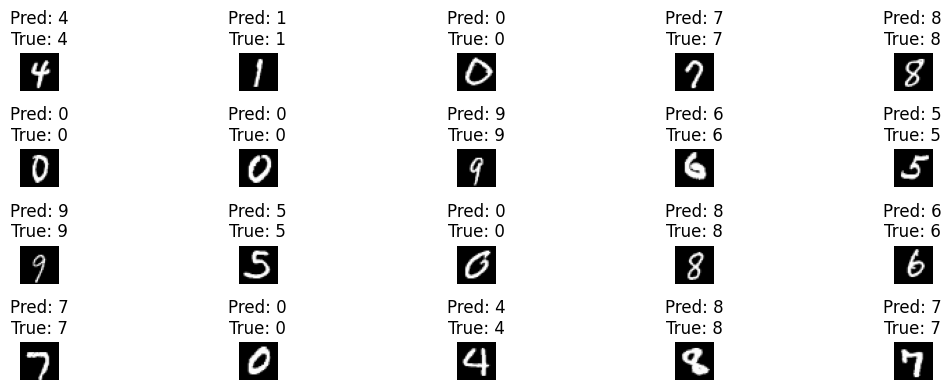

In [13]:
model.eval()
images, labels = next(iter(val_data))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Plot 10 test images with predictions
plt.figure(figsize=(12, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# #to print dim
# images, labels = next(iter(train_data))
# print(images.shape)
# patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size= patch_size, stride= patch_size)
# embedded_image = patch_embed(images)
# print(embedded_image.shape)
# print(embedded_image.flatten(2).shape)
# print(embedded_image.flatten(2).transpose(1,2).shape)

